In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import font_manager

from scipy.interpolate import interp2d
import scipy.integrate as intg
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
import matplotlib.cm as cm
import matplotlib.colors as colors

#
# Disk density structure 
#
def Fct(w):
    global au,rs,ts,beta,alpha,h100,Lum,tstar,rstar
    return 2.*np.pi*w*(1.-np.sqrt(rstar/w)) * (rstar/w)**alpha * np.sqrt(2.*np.pi) * h100 * (w/(100.*au))**beta

# Register the font
font_path = '/usr/share/fonts/liberation-sans/LiberationSans-Regular.ttf'
font_manager.fontManager.addfont(font_path)

# Get the actual family name (it must match the internal font name)
liberation = font_manager.FontProperties(fname=font_path)
font_name = liberation.get_name()  # usually "Liberation Sans"
print(font_name)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# Set it globally
plt.rcParams['font.family'] = font_name
plt.rcParams['font.sans-serif'] = [font_name]

plt.rcParams.update({
    'axes.linewidth': 0.5,      # axes spines
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.minor.width': 0.3,
    'ytick.minor.width': 0.3,
})

#
# Some natural constants
#
yr  = 365.0*24.0*3600.
au  = 1.49598e13     # Astronomical Unit       [cm]
pc  = 3.08572e18     # Parsec                  [cm]
ms  = 1.98892e33     # Solar mass              [g]
ts  = 5.78e3         # Solar temperature       [K]
ls  = 3.8525e33      # Solar luminosity        [erg/s]
rs  = 6.96e10        # Solar radius            [cm]
me  = 5.972e27       # Earth mass              [g]
Gconst = 6.6743e-8 # Gravitational constant  [cm^3/g s^2]
kb  = 1.38e-16      # Boltzmann constant, in Gaussian units
mu_atom = 1.6735E-24  # atomic mass  [g]
mbar = 2.3            # Mean molecular mass
H2mass= 1.6735E-24*2.   # H2 mass  [g] 수소 분자 질량
dustmass= H2mass / 100.    # dust mass [g] (gas to dust ratio is 100)

Liberation Sans


# 1. Vertical Mixing Timescale

## EC 53 model parameters

In [3]:
# Stellar Parameter
mstar    = 0.5*ms              # EC 53, Baek et al. 2020, section 2
rstar    = 2.09*rs             # EC 53, Baek et al. 2020, section 2
tstar    = 4E+3                # EC 53, Baek et al. 2020, section 2
alpha_vis = 0.01 #0.3                # EC 53, Lee et al. 2020, section 4

# Stellar Parameter
Mdisk = 0.0075*ms              # fixed parameter
rd_in = 33.*rstar               # Change this value for T_dust < 1200K, 65
rd_in_gs = 35*rstar            # fixed parameter, fiducial model in Baek et al. 2020
rd_out = 90.*au                # fixed parameter
h100 = 48.*au
alpha = 2.5                    # fixed parameter
beta = 1.3                     # fixed parameter
den_disk = intg.quad(Fct,rd_in,rd_out)
den_disk0 = Mdisk / den_disk[0]

## Model grid parameters

In [4]:
#
# Grid parameters
#
nx       = 500        # nr 
ny       = 500        # One-sided only. So the "real" value is twice this.
nz       = 1

# xi, yi, zi are the walls of the grid in each direction 
xi       = rd_in * (rd_out/rd_in)**(np.linspace(0.,nx,nx+1)/(nx*1.0))   # r grid for entire system: from disk inner radius (rd_in [cm]) to envelope outer radius (re_out [cm])
yi       = np.arccos((np.linspace(ny,0,ny+1)/(ny*1.0))**1.0)        # theta grid for 0-90 degree (since we assume axisymmetric system)
zi       = [0., 0.]                                                     # phi grid (set 0 in 2d case)
#zi       = np.array([0.,math.pi*2])

# xc, yc are the centers of the grid in each direction
xc       = 0.5e0 * ( xi[:-1] + xi[1:] )
yc       = 0.5e0 * ( yi[:-1] + yi[1:] )

# space grid position value
ra       = np.array(xi[0:nx])
rb       = np.array(xi[1:nx+1])
za       = np.array(np.cos(yi)[0:ny])
zb       = np.array(np.cos(yi)[1:ny+1])

sigma=np.zeros([nx,ny])
rhod=np.zeros([nx,ny])
H=np.zeros([nx,ny])
for it in range(ny): 
    for ir in range(nx): 
        w = xc[ir]*np.sin(yc[it])
        z = xc[ir]*np.cos(yc[it])
        
        h = h100* (w/(100*au))**beta
        gexp = (z / h)**2

        # Volume density calculation
        den_disk_eq = den_disk0 * (1. - np.sqrt(rstar / w)) * (rstar / w)**alpha * np.exp(-0.5 * gexp)

        # Surface density calculation
        sigma_disk_eq = np.sqrt(2. * np.pi) * h * den_disk_eq  # Σ = sqrt(2π) * H * ρ_mid
        
        sigma[ir,it] = sigma_disk_eq
        rhod[ir,it] = den_disk_eq
        H[ir,it] = h
rhod = rhod[:,-1]        
sigma = sigma[:,-1]
H = H[:,-1]

## Calculate vertical mixing timescale

In [5]:
def miplane(tdustfile):
    dtype_m = [('ra', 'f'), ('rb', 'f'), ('za', 'f'), ('zb', 'f'), ('tdust', 'f'), ('ndust', 'f')]
    data = np.genfromtxt(tdustfile, dtype=dtype_m, comments='#',skip_header=0)
    
    ra = data['ra'] ; rb = data['rb'] ; rr = (ra+rb)/2
    za = data['za'] ; zb = data['zb'] ; zz = (za+zb)/2
    
    tdust = data['tdust'] ; ndust = data['ndust']
    
    mid_idx = np.where(zz == np.min(zz))
    
    tdust_mid = tdust[mid_idx] ; ndust_mid = ndust[mid_idx]
    return rr[mid_idx], tdust_mid, ndust_mid

path = "./"
qui_filename = "tdustpdr_ec53_006lsun_nr500_disk.txt"
bur_filename = "tdustpdr_ec53_bur_nr500_disk.txt"

tdustfile = path+qui_filename

rr_mid, tdust_mid, ndust_mid = miplane(tdustfile)

# Vertical mixing timescale
tau_ver_1e0 = 15.93*(0.01/1)*(rr_mid/au)**(3/2)*(mstar/ms)
tau_ver_1e1 = 15.93*(0.01/0.1)*(rr_mid/au)**(3/2)*(mstar/ms)
tau_ver_1e2 = 15.93*(0.01/0.01)*(rr_mid/au)**(3/2)*(mstar/ms)
tau_ver_1e3 = 15.93*(0.01/0.001)*(rr_mid/au)**(3/2)*(mstar/ms)
tau_ver_1e4 = 15.93*(0.01/0.0001)*(rr_mid/au)**(3/2)*(mstar/ms)

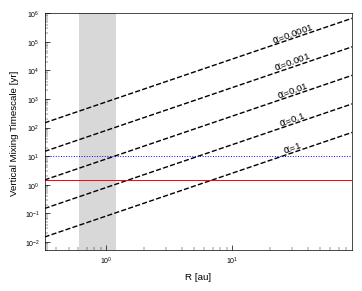

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8.9/2.54, 8.9/2.54*0.8), constrained_layout=True)

ax.loglog(rr_mid/au,tau_ver_1e0,color='k',linestyle='--',linewidth=1)
ax.loglog(rr_mid/au,tau_ver_1e1,color='k',linestyle='--',linewidth=1)
ax.loglog(rr_mid/au,tau_ver_1e2,color='k',linestyle='--',linewidth=1)
ax.loglog(rr_mid/au,tau_ver_1e3,color='k',linestyle='--',linewidth=1)
ax.loglog(rr_mid/au,tau_ver_1e4,color='k',linestyle='--',linewidth=1)


labels = [r"$\rm \alpha$=1", r"$\rm \alpha$=0.1", r"$\rm \alpha$=0.01", r"$\rm \alpha$=0.001", r"$\rm \alpha$=0.0001"]

for label, tau in zip(labels, 
                             [tau_ver_1e0, tau_ver_1e1, tau_ver_1e2, tau_ver_1e3, tau_ver_1e4]):
    # y 위치를 선 데이터에서 계산
    y_pos = tau[(rr_mid / au >= 30).argmax()]  # x_pos에 가장 가까운 y 값
    ax.text(30, y_pos*1.6, label, fontsize=7, rotation=20, va='center', ha='center')

ax.axhline(1.5, c='r', lw=0.7)
ax.axhline(10, c='b', lw=0.7, ls=':')
# ax.scatter(1.2,10,c='b',zorder=10,s=20)

x_fill = rr_mid / au 
y_min = 0       
y_max = 1e10 
ax.fill_between(x_fill, y_min, y_max, where=(x_fill >= 0.6) & (x_fill <= 1.2), color='gray', alpha=0.3, ec=None)

ax.set_xlabel("R [au]", fontsize=7)
ax.set_ylabel("Vertical Mixing Timescale [yr]", fontsize=7)
ax.set_xlim([np.min(rr_mid/au),np.max(rr_mid/au)])
ax.set_ylim([5e-3, 1.0e6])

ax.tick_params(axis='both', which='major', labelsize=5)

fig.set_size_inches(8.9/2.54, 8.9/2.54*0.8)

plt.savefig("Final_FigExt8.pdf", bbox_inches=None)


# 2. Crystallized regions

In [27]:
# Dust Parameter
nu = 2.0e13   # mean vibrational frequency of the magnesium-silicate lattice [s-1]
Eak_for = 39100   # activation energy for forsterite (crystalline Mg2SiO4) [K]
Eak_ens = 42040   # activation energy for enstatite (crystalline MgSiO3) [K]
Eak_qua = 49000   # activation energy for quartz (crystalline SiO2) [K]

# Disk Parameter
h100 = 48.*au  # Disk scale height
beta = 1.3     # Flare power index

# Model grid & temperature / density
def dustmodel(tdustfile):
    dtype_m = [('ra', 'f'), ('rb', 'f'), ('za', 'f'), ('zb', 'f'), ('tdust', 'f'), ('ndust', 'f')]
    data = np.genfromtxt(tdustfile, dtype=dtype_m, comments='#', skip_header=0)

    ra = data['ra']; rb = data['rb']
    za = data['za']; zb = data['zb']
    tdust = data['tdust']; ndust = data['ndust']
    
    return  ra, rb, za, zb, tdust, ndust

# Crystallization area
def dust_crystallization(tdustfile,Eak, alpha):
    dtype_m = [('ra', 'f'), ('rb', 'f'), ('za', 'f'), ('zb', 'f'), ('tdust', 'f'), ('ndust', 'f')]
    data = np.genfromtxt(tdustfile, dtype=dtype_m, comments='#', skip_header=0)

    ra = data['ra']; rb = data['rb']
    za = data['za']; zb = data['zb']
    tdust = data['tdust']; ndust = data['ndust']

    rr = (ra + rb) / 2.0  # radius of grid
    zz = (za + zb) / 2.0  # mean zenith of grid
    z1 = rr * za          # zenith of grid

    H = h100 * (rr / (100 * au)) ** beta

    # Timescales
    tau_cryst = (1.0 / nu) * np.exp(Eak / tdust) / yr
    tau_res = 1.76 * ((3 * H) / z1) ** 2 * (0.01 / alpha) * (rr / au) ** (3 / 2) * (mstar / ms)

    # Crystallized dust mass
    idx_crst = np.where((tau_cryst < tau_res) & (tdust>700.) & (tau_cryst < 1.5))
    xi_crst = ra[idx_crst]; xi1_crst = rb[idx_crst]
    cosyi1_crst = za[idx_crst]; cosyi_crst = zb[idx_crst]
    rhod_crst = ndust[idx_crst]
    
    xi_crst = np.array(xi_crst, dtype=np.float64)
    xi1_crst = np.array(xi1_crst, dtype=np.float64)

    del_v1_crst = 4.0 / 3.0 * np.pi * ((xi1_crst ** 3) - (xi_crst ** 3)) * (cosyi_crst - cosyi1_crst)
    mass_crst = np.sum(del_v1_crst * rhod_crst) / ms

    # Crystallization mass ratio
    idx_nomid = np.where((tau_cryst < tau_res) & (rr*zz > 0.01*au))
    idx_inner = np.where(rr <= max(rr[idx_nomid]))
    rr_inner = max(rr[idx_inner] / au)

    xi_inner = ra[idx_inner]; xi1_inner = rb[idx_inner]
    cosyi1_inner = za[idx_inner]; cosyi_inner = zb[idx_inner]
    rhod_inner = ndust[idx_inner]
    
    xi_inner = np.array(xi_inner, dtype=np.float64)
    xi1_inner = np.array(xi1_inner, dtype=np.float64)

    del_v1_inner = 4.0 / 3.0 * np.pi * ((xi1_inner ** 3) - (xi_inner ** 3)) * (cosyi_inner - cosyi1_inner)
    mass_inner = np.sum(del_v1_inner * rhod_inner) / ms

    mass_ratio = mass_crst / mass_inner
    
    return  rr_inner, mass_inner, idx_crst, mass_crst, mass_ratio, tau_cryst, tau_res

## Calculate crystalized regions

In [28]:
qui_data = path+qui_filename
bur_data = path+bur_filename

# Quiescent phase models
ra_q, rb_q, za_q, zb_q, tdust_q, ndust_q = dustmodel(qui_data)
rr_q = (ra_q + rb_q) / 2.  # radius of grid
zz_q = (za_q + zb_q) / 2.    # zenith of grid

rr_inner_qf, mass_inner_qf, idx_crst_qf, mass_crst_qf, mass_ratio_qf,tau_cryst_qf, tau_res_qf = dust_crystallization(qui_data,Eak_for,alpha_vis)
rr_inner_qe, mass_inner_qe, idx_crst_qe, mass_crst_qe, mass_ratio_qe,tau_cryst_qe, tau_res_qe = dust_crystallization(qui_data,Eak_ens,alpha_vis)
rr_inner_qq, mass_inner_qq, idx_crst_qq, mass_crst_qq, mass_ratio_qq,tau_cryst_qq, tau_res_qq = dust_crystallization(qui_data,Eak_qua,alpha_vis)

# Burst phase models
ra_b, rb_b, za_b, zb_b, tdust_b, ndust_b = dustmodel(bur_data)
rr_b = (ra_b + rb_b) / 2.  # radius of grid
zz_b = (za_b + zb_b) / 2.    # zenith of grid

rr_inner_bf, mass_inner_bf, idx_crst_bf, mass_crst_bf, mass_ratio_bf,tau_cryst_bf, tau_res_bf = dust_crystallization(bur_data,Eak_for,alpha_vis)
rr_inner_be, mass_inner_be, idx_crst_be, mass_crst_be, mass_ratio_be,tau_cryst_be, tau_res_be = dust_crystallization(bur_data,Eak_ens,alpha_vis)
rr_inner_bq, mass_inner_bq, idx_crst_bq, mass_crst_bq, mass_ratio_bq,tau_cryst_bq, tau_res_bq = dust_crystallization(bur_data,Eak_qua,alpha_vis)

/tmp/ipykernel_3842421/3597794998.py:38: RuntimeWarning: divide by zero encountered in divide
  tau_cryst = (1.0 / nu) * np.exp(Eak / tdust) / yr
/tmp/ipykernel_3842421/3597794998.py:38: RuntimeWarning: overflow encountered in exp
  tau_cryst = (1.0 / nu) * np.exp(Eak / tdust) / yr
/tmp/ipykernel_3842421/3597794998.py:39: RuntimeWarning: divide by zero encountered in divide
  tau_res = 1.76 * ((3 * H) / z1) ** 2 * (0.01 / alpha) * (rr / au) ** (3 / 2) * (mstar / ms)


## Masking for plot

In [29]:
# Quiescent phase 데이터
points_q = np.array([rr_q / au, (rr_q * zz_q) / au]).T
values_q = np.log10(tdust_q)
grid_x_q, grid_y_q = np.linspace(0.3, 2.0, 500), np.linspace(0.0, 1.0, 500)
grid_X_q, grid_Y_q = np.meshgrid(grid_x_q, grid_y_q)
grid_Z_q = griddata(points_q, values_q, (grid_X_q, grid_Y_q), method='linear')

mask_crst_forsterite_q = np.zeros_like(rr_q)
mask_crst_forsterite_q[idx_crst_qf] = 1
grid_mask_forsterite_q = griddata(points_q, mask_crst_forsterite_q, (grid_X_q, grid_Y_q), method='linear')

mask_crst_enstatite_q = np.zeros_like(rr_q)
mask_crst_enstatite_q[idx_crst_qe] = 1
grid_mask_enstatite_q = griddata(points_q, mask_crst_enstatite_q, (grid_X_q, grid_Y_q), method='linear')

mask_crst_quartz_q = np.zeros_like(rr_q)
mask_crst_quartz_q[idx_crst_qq] = 1
grid_mask_quartz_q = griddata(points_q, mask_crst_quartz_q, (grid_X_q, grid_Y_q), method='linear')

# Burst phase 데이터
points_b = np.array([rr_b / au, (rr_b * zz_b) / au]).T
values_b = np.log10(tdust_b)
grid_x_b, grid_y_b = np.linspace(0.3, 2.0, 500), np.linspace(0.0, 1.0, 500)
grid_X_b, grid_Y_b = np.meshgrid(grid_x_b, grid_y_b)
grid_Z_b = griddata(points_b, values_b, (grid_X_b, grid_Y_b), method='linear')

mask_crst_forsterite_b = np.zeros_like(rr_b)
mask_crst_forsterite_b[idx_crst_bf] = 1
grid_mask_forsterite_b = griddata(points_b, mask_crst_forsterite_b, (grid_X_b, grid_Y_b), method='linear')

mask_crst_enstatite_b = np.zeros_like(rr_b)
mask_crst_enstatite_b[idx_crst_be] = 1
grid_mask_enstatite_b = griddata(points_b, mask_crst_enstatite_b, (grid_X_b, grid_Y_b), method='linear')

mask_crst_quartz_b = np.zeros_like(rr_b)
mask_crst_quartz_b[idx_crst_bq] = 1
grid_mask_quartz_b = griddata(points_b, mask_crst_quartz_b, (grid_X_b, grid_Y_b), method='linear')

/tmp/ipykernel_3842421/2915124002.py:3: RuntimeWarning: divide by zero encountered in log10
  values_q = np.log10(tdust_q)
/tmp/ipykernel_3842421/2915124002.py:22: RuntimeWarning: divide by zero encountered in log10
  values_b = np.log10(tdust_b)


/tmp/ipykernel_3842421/2243058930.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.2)


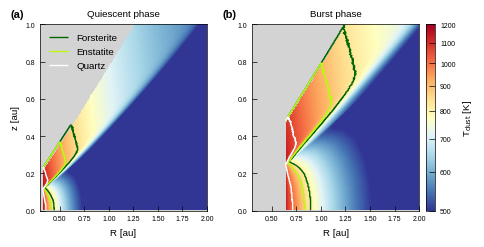

In [44]:

fig, axs = plt.subplots(1, 2, figsize=(12/2.54, 12/2.54*0.5), constrained_layout=True)
plt.subplots_adjust(wspace=0.2)

fig.patch.set_facecolor('w')
axs[0].set_facecolor('lightgray')
axs[1].set_facecolor('lightgray')

# Quiescent phase 플롯
im0 = axs[0].imshow(grid_Z_q, extent=(0.3, 2.0, 0.0, 1.0), origin='lower', aspect='auto', cmap='RdYlBu_r', vmin=np.log10(500), vmax=np.log10(1200))
cs1_q = axs[0].contour(grid_X_q, grid_Y_q, grid_mask_forsterite_q, levels=[0.5], colors='darkgreen', linewidths=1)
cs2_q = axs[0].contour(grid_X_q, grid_Y_q, grid_mask_enstatite_q, levels=[0.5], colors='xkcd:yellowgreen', linewidths=1)
cs3_q = axs[0].contour(grid_X_q, grid_Y_q, grid_mask_quartz_q, levels=[0.5], colors='w', linewidths=1)

h1,_ = cs1_q.legend_elements()
h2,_ = cs2_q.legend_elements()
h3,_ = cs3_q.legend_elements()
axs[0].legend([h1[0], h2[0], h3[0]], ['Forsterite', 'Enstatite', 'Quartz'],loc='upper left',fontsize=7, frameon=False)

axs[0].set_title("Quiescent phase", fontsize=7)
axs[0].set_xlabel("R [au]", fontsize=7)
axs[0].set_ylabel("z [au]", fontsize=7)

# Burst phase 플롯
im1 = axs[1].imshow(grid_Z_b, extent=(0.3, 2.0, 0.0, 1.0), origin='lower', aspect='auto', cmap='RdYlBu_r', vmin=np.log10(500), vmax=np.log10(1200))
axs[1].contour(grid_X_b, grid_Y_b, grid_mask_forsterite_b, levels=[0.5], colors='darkgreen', linewidths=1)
axs[1].contour(grid_X_b, grid_Y_b, grid_mask_enstatite_b, levels=[0.5], colors='xkcd:yellowgreen', linewidths=1)
axs[1].contour(grid_X_b, grid_Y_b, grid_mask_quartz_b, levels=[0.5], colors='w', linewidths=1)
axs[1].set_title("Burst phase", fontsize=7)
axs[1].set_xlabel("R [au]", fontsize=7)


axs[0].tick_params(axis='both', which='major', labelsize=5)
axs[1].tick_params(axis='both', which='major', labelsize=5)

# 공통 Colorbar 추가
vmin = np.log10(500)
vmax = np.log10(1200)
cmap = cm.RdYlBu_r
norm = colors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

tick_vals = np.array([500, 600, 700, 800, 900, 1000, 1100, 1200])
log_ticks = np.log10(tick_vals)

cb = fig.colorbar(sm, ax=axs, orientation="vertical",
                  fraction=0.05, pad=0)
cb.set_label(r"T$_{\rm dust}$ [K]", fontsize=7)

cb.set_ticks(log_ticks)
cb.set_ticklabels([str(v) for v in tick_vals], fontsize=5)
cb.ax.tick_params(which='both', direction='in', length=4, labelsize=5)
#cb.ax.tick_params(which='minor', length=0)
#cb.ax.tick_params(which='major', length=8, width=2.5)

axs[0].text(-0.18, 1.08, '(a)', transform=axs[0].transAxes, fontsize=8, fontweight='bold', va='top', ha='left')
axs[1].text(-0.18, 1.08, '(b)', transform=axs[1].transAxes, fontsize=8, fontweight='bold', va='top', ha='left')


plt.savefig("Final_Fig3.pdf", bbox_inches=None)
